### Model Predicting Fire & Non Fire Using Thermal Hot Images  

In [50]:
import keras
from keras.layers import Input, Lambda
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from tqdm import tqdm

In [51]:
import pickle

pickle_in = open("X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_train.pickle","rb")
y_train = pickle.load(pickle_in)

pickle_in = open("X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("y_test.pickle","rb")
y_test = pickle.load(pickle_in)


MemoryError: 

In [9]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((39375, 224, 224, 1), (39375,), (8617, 224, 224, 1), (8617,))

In [16]:
X_train = X_train.reshape(len(X_train), -1)
X_test  = X_test.reshape(len(X_test), -1)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((39375, 50176), (39375,), (8617, 50176), (8617,))

In [28]:
y_test.dtype

dtype('int32')

In [43]:
X_train = X_train.astype('uint8')
y_train = y_train.astype('uint8')

In [44]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [45]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [46]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [48]:
xgbc = xgboost.XGBClassifier()

random_search = RandomizedSearchCV( xgbc , param_distributions = params , n_iter=2 , scoring='roc_auc' , n_jobs=-1 , cv=5 , verbose = 3)

from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 2 candidates, totalling 10 fits


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
random_search.best_estimator_

In [ ]:
random_search.best_params_

In [ ]:
from  xgboost import XGBClassifier 
xgbc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
xgbc.fit(X_train,y_train)
y_xgbcPred = xgbc.predict(X_test)

In [ ]:
Trainscore = xgbc.score(X_train,y_train)*100
Testscore  = xgbc.score(X_test,y_test)*100
print("Training Score  :" , Trainscore)
print("Testing Score  :" , Testscore)

----------------------------------------------

### Feature Extraction Using Filters

In [20]:
###################################################################
# FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, :,:,:]
        img = input_img
        
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
         # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        
        #df['Image_Name'] = image   #Capture image name as we read multiple images
        
        # FEATURE 2 - Bunch of Gabor filter responses
        
                #Generate Gabor features
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
    #                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
         
        # FEATURE 3 Sobel
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1
       
        #Add more filters as needed
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [21]:
#Extract features from training images
image_features = feature_extractor(x_train)

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5


In [22]:
print(500*224*224*3)

x_train.shape

75264000


(500, 224, 224, 3)

In [23]:
image_features.shape

(75264000, 6)

In [24]:
#Reshape to a vector for Random Forest / SVM training
n_features = image_features.shape[1]

image_features = np.expand_dims(image_features, axis=0)

X_for_RF = np.reshape(image_features, (x_train.shape[0], -1))  #Reshape to #images, features

In [25]:
n_features

6

In [26]:
image_features.shape

(1, 75264000, 6)

In [27]:
X_for_RF.shape

(500, 903168)

In [28]:
#Define the classifier
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [29]:
# Fit the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(random_state=42)

In [30]:
#Can also use SVM but RF is faster and may be more accurate.
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(X_for_RF, y_train)

SVC(decision_function_shape='ovo')

### Testing Model

In [31]:
#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

In [32]:
#Predict on test using RF
test_prediction = RF_model.predict(test_for_RF)

In [33]:
#Predict on test using SVM
test_pred = SVM_model.predict(test_for_RF)

In [34]:
#Inverse le transform to get original label back for RF
test_prediction = le.inverse_transform(test_prediction)

In [35]:
#Inverse le transform to get original label back for SVM
test_pred = le.inverse_transform(test_pred)

In [36]:
#Print overall accuracy of RF
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_prediction))

Accuracy =  0.96


In [37]:
#Print overall accuracy of SVM
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_pred))

Accuracy =  0.94


<AxesSubplot:>

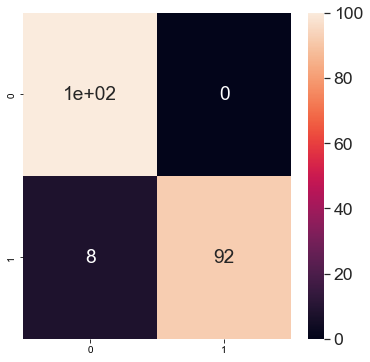

In [38]:
#Print confusion matrix of RF
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_prediction)

fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

<AxesSubplot:>

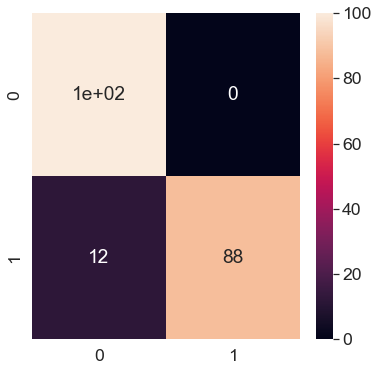

In [39]:
#Print confusion matrix of SVM
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_pred)

fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
The prediction for this image is:  ['Fire']
The actual label for this image is:  Fire


C:\Users\Lenovo\anaconda3\envs\myDL\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


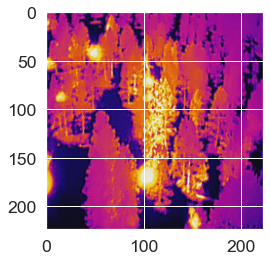

In [40]:
#Check results on a few random images for RF
import random
n=random.randint(0, x_test.shape[0]-1) #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = RF_model.predict(input_img_for_RF)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", test_labels[n])

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
The prediction for this image is:  ['Fire']
The actual label for this image is:  Fire


C:\Users\Lenovo\anaconda3\envs\myDL\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


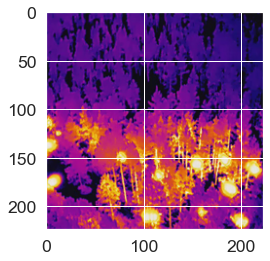

In [50]:
#Check results on a few random images of SVM
import random
n=random.randint(0, x_test.shape[0]-1) #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_SVM = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = SVM_model.predict(input_img_for_SVM)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", test_labels[n])

{'Fire': 0, 'No_Fire': 1}
Original Image Shape (224, 224, 3)
Expanded Image Shape (1, 224, 224, 3)
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Featured Image Shape (150528, 6)
Expanded featured Image Shape (1, 150528, 6)
Reshaping featured Image into single vector  (1, 903168)
The prediction for this image is:  ['Fire']
The actual label for this image is fire


C:\Users\Lenovo\anaconda3\envs\myDL\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


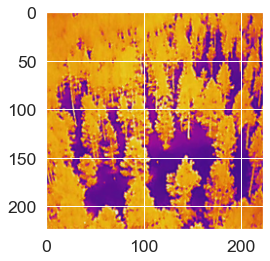

In [52]:
from PIL import Image , ImageOps , ImageEnhance
print(classes)
img = Image.open("./Datasets/Image 12624.jpg")

# img = ImageOps.grayscale(img)
# img = ImageEnhance.Contrast(img).enhance(2)
# img = ImageEnhance.Sharpness(img).enhance(50)
# img = ImageEnhance.Brightness(img).enhance(1)

img = img.resize((SIZE,SIZE))

plt.imshow(img)

img = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

print("Original Image Shape",img.shape)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)

print("Expanded Image Shape",input_img.shape)

input_img_features=feature_extractor(input_img)

print("Featured Image Shape",input_img_features.shape)

input_img_features = np.expand_dims(input_img_features, axis=0)

print("Expanded featured Image Shape",input_img_features.shape)

input_img_for_RF=np.reshape(input_img_features, (input_img.shape[0], -1))

print("Reshaping featured Image into single vector ",input_img_for_SVM.shape)

#Predict
img_prediction = RF_model.predict(input_img_for_RF)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name

print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is fire")